In [1]:
from typing import List, Set, Any, Tuple, Dict, Union
from collections.abc import Sequence

import random
from fuzzingbook.Coverage import population_coverage

In [2]:
class Mutator:
    def __init__(self) -> None:
        self.mutators = [
            self.delete_random_character,
            self.insert_random_character,
            self.flip_random_character,
        ]

In [3]:
class Mutator(Mutator):
    def insert_random_character(self, s: str) -> str:
        pos = random.randint(0, len(s))
        random_character = chr(random.randrange(32, 127))
        return s[:pos] + random_character + s[pos:]

    def delete_random_character(self, s: str) -> str:
        if s == "":
            return self.insert_random_character(s)

        pos = random.randint(0, len(s) - 1)
        return s[:pos] + s[pos + 1 :]

    def flip_random_character(self, s: str) -> str:
        if s == "":
            return self.insert_random_character

        pos = random.randint(0, len(s) - 1)
        c = s[pos]
        bit = 1 << random.randint(0, 6)
        new_c = chr(ord(c) ^ bit)

        return s[:pos] + new_c + s[pos + 1 :]

    def mutate(self, inp: Any) -> Any:
        mutator = random.choice(self.mutators)
        return mutator(inp)


Mutator().mutate("good")

'ood'

In [4]:
from fuzzingbook.Coverage import Location


class Seed:
    def __init__(self, data: str) -> None:
        self.data = data
        self.coverage: Set[Location] = set()
        self.distance: Union[int, float] = -1
        self.energy = 0.0

    def __str__(self) -> str:
        return self.data

    __repr__ = __str__

In [5]:
class PowerSchedule:
    def __init__(self) -> None:
        self.path_frequency: Dict = {}

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        for seed in population:
            seed.energy = 1

    def normalizedEnergy(self, population: Sequence[Seed]) -> List[float]:
        energy = list(map(lambda seed: seed.energy, population))
        sum_energy = sum(energy)
        assert sum_energy != 0
        norm_energy = list(map(lambda nrg: nrg / sum_energy, energy))
        return norm_energy

    def choose(self, population: Sequence[Seed]) -> Seed:
        self.assignEnergy(population)
        norm_energy = self.normalizedEnergy(population)
        seed: Seed = random.choices(population, weights=norm_energy)[0]
        return seed

In [6]:
population = [Seed("A"), Seed("B"), Seed("C")]

schedule = PowerSchedule()

hits = {"A": 0, "B": 0, "C": 0}

for i in range(10000):
    seed = schedule.choose(population)
    hits[seed.data] += 1

In [7]:
hits

{'A': 3373, 'B': 3317, 'C': 3310}

In [8]:
from fuzzingbook.MutationFuzzer import FunctionCoverageRunner, http_program


def crashme(s: str) -> None:
    if len(s) > 0 and s[0] == "b":
        if len(s) > 1 and s[1] == "a":
            if len(s) > 2 and s[2] == "d":
                if len(s) > 3 and s[3] == "!":
                    raise Exception()


crashme_runner = FunctionCoverageRunner(crashme)
crashme_runner.run("good")
list(crashme_runner.coverage())

[('crashme', 5), ('run_function', 410)]

In [ ]:
from fuzzingbook.Fuzzer import Fuzzer


class AdvancedMutationFuzzer(Fuzzer):
    def __init__(
        self, seeds: List[str], mutator: Mutator, schedule: PowerSchedule
    ) -> None:
        self.seeds = seeds
        self.mutator = mutator
        self.schedule = schedule
        self.inputs: List[str] = []
        self.reset()

    def reset(self) -> None:
        self.population = list(map(lambda x: Seed(x), self.seeds))
        self.seed_index = 0

    def create_candidate(self) -> str:
        seed = self.schedule.choose(self.population)
        candidate = seed.data
        trials = min(len(candidate), 1 << random.randint(1, 5))
        for i in range(trials):
            candidate = self.mutator.mutate(candidate)
        return candidate

    def fuzz(self) -> str:
        if self.seed_index < len(self.seeds):
            self.inp = self.seeds[self.seed_index]
            self.seed_index += 1
        else:
            self.inp = self.create_candidate()

        self.inputs.append(self.inp)

        return self.inp

In [ ]:
seed_input = "good"
mutation_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())

good
oo'~
{oeood


In [ ]:
import time

n = 30000

blackbox_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
start = time.time()
blackbox_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

In [ ]:
"It took the blackbox mutation-based fuzzer %0.2f seconds to generate and execute %d inputs." % (
    end - start,
    n,
)

'It took the blackbox mutation-based fuzzer 0.38 seconds to generate and execute 30000 inputs.'

In [ ]:
_, blackbox_coverage = population_coverage(blackbox_fuzzer.inputs, crashme)
bb_max_coverage = max(blackbox_coverage)
print(
    f"The blackbox mutation based fuzzer got a max coverage of {bb_max_coverage} statements"
)

The blackbox mutation based fuzzer got a max coverage of 2 statements


In [ ]:
[seed_input] + [
    blackbox_fuzzer.inputs[idx]
    for idx in range(len(blackbox_coverage))
    if blackbox_coverage[idx] > blackbox_coverage[idx - 1]
]

['good', 'bGo']

In [ ]:
class GreyboxFuzzer(AdvancedMutationFuzzer):
    def reset(self):
        super().reset()
        self.coverages_seen = set()
        self.population = []

    def run(self, runner: FunctionCoverageRunner) -> Tuple[Any, str]:
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if new_coverage not in self.coverages_seen:
            seed = Seed(self.inp)
            seed.coverage = runner.coverage()
            self.coverages_seen.add(new_coverage)
            self.population.append(seed)

        return (result, outcome)

In [ ]:
seed_input = "good"
greybox_fuzzer = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())

start = time.time()
greybox_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()
print(f"Time taken by Greybox Fuzzer {end-start:.2f}, generated {n} inputs")

Time taken by Greybox Fuzzer 0.46, generated 30000 inputs


In [ ]:
_, greybox_coverage = population_coverage(greybox_fuzzer.inputs, crashme)
gb_max_coverage = max(greybox_coverage)
print(f"Greybox covered {gb_max_coverage - bb_max_coverage} more statemets ")

Greybox covered 3 more statemets 


In [20]:
greybox_fuzzer.population

[good, bg-d, bad, ba d, bad!X`]

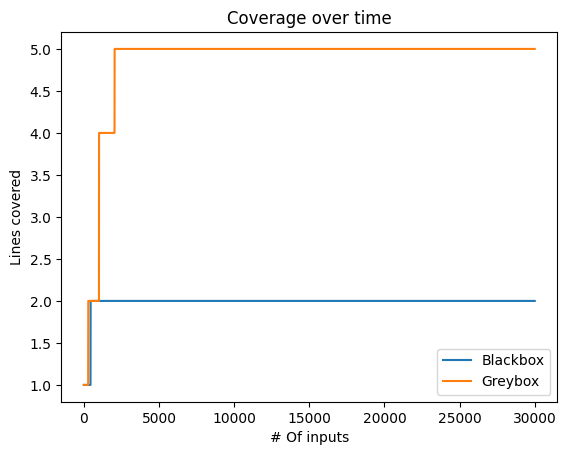

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

line_bb, = plt.plot(blackbox_coverage, label="Blackbox")
line_gb, = plt.plot(greybox_coverage, label="Greybox")

plt.legend(handles=[line_bb, line_gb])
plt.title('Coverage over time')
plt.xlabel('# Of inputs')
plt.ylabel('Lines covered')
plt.show()


In [ ]:
import pickle, hashlib


def getPathID(coverage: Any) -> str:
    pickled = pickle.dumps(sorted(coverage))
    return hashlib.md5(pickled).hexdigest()

In [ ]:
class AFLFastSchedule(PowerSchedule):
    def __init__(self, exponent: float) -> None:
        self.exponent = exponent

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        for seed in population:
            seed.energy = 1 / (
                self.path_frequency[getPathID(seed.coverage)] ** self.exponent
            )


class CountingGreyboxFuzzer(GreyboxFuzzer):
    def reset(self):
        super().reset()
        self.schedule.path_frequency = {}

    def run(self, runner: FunctionCoverageRunner) -> Tuple[Any, str]:
        result, outcome = super().run(runner)

        path_id = getPathID(runner.coverage())
        if path_id not in self.schedule.path_frequency:
            self.schedule.path_frequency[path_id] = 1
        else:
            self.schedule.path_frequency[path_id] += 1

        return (result, outcome)


n = 10000
seed_input = "good"
fast_schedule = AFLFastSchedule(5)
fast_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), fast_schedule)
start = time.time()
fast_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

"It took the fuzzer w/ exponential schedule %0.2f seconds to generate and execute %d inputs." % (
    end - start,
    n,
)

'It took the fuzzer w/ exponential schedule 0.35 seconds to generate and execute 10000 inputs.'

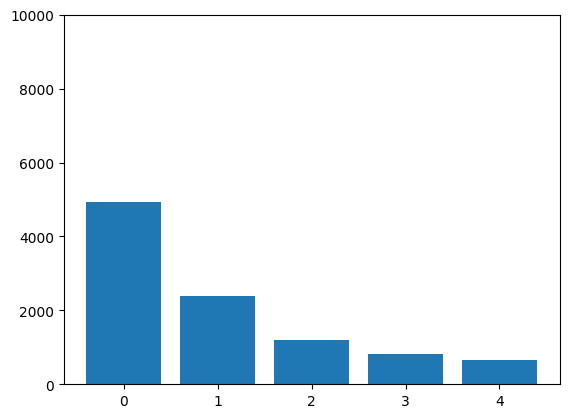

In [ ]:
import numpy as np

x_axis = np.arange(len(fast_schedule.path_frequency))
y_axis = list(fast_schedule.path_frequency.values())

plt.bar(x_axis, y_axis)
plt.xticks(x_axis)
plt.ylim(0, n)
plt

In [28]:
print("             path id 'p'           : path frequency 'f(p)'")
fast_schedule.path_frequency

             path id 'p'           : path frequency 'f(p)'


{'f1bc2f03020c9cfa40ef926855aa2272': 4931,
 '44455a9bdbeef103dcdf39eb0614386f': 2394,
 '11c535c3525708675737c4f60335ec99': 1201,
 '3cdffdcf11ad785bb46869435d59c204': 809,
 'b58f7b3918bc4c35c007bc69e3f34786': 665}